In [1]:
import seaborn as sb
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels 
import scipy

# Load the CSV file
df = pd.read_csv("//Users//yuzetsai//Desktop//untitled folder//final.csv")
print(df.columns)

Index(['year', 'city/county', 'Household_income',
       'General_waste_recycling_rate',
       'Budget_structure_ratio_for_environmental',
       'Proportion_of_environmental_fines', 'number_of_people',
       'per_capita_electricity_usage', 'per_capita_incinerated_waste_kg',
       'per_capita_landfilled_waste_kg',
       'per_capita_resource_recovery_by_local_authorities_kg',
       'per_capita_generation_of_general_waste_kg',
       'per_capita_t_capacity_of_renewable_energy', 'Vancancy_rate',
       'per_capita_food_waste_kg'],
      dtype='object')


In [2]:

df_sub = df.iloc[:, [2,3,4,5,7,8,9,10,11,12,13,14]]
print(df_sub.columns)

# Now df_sub should be defined and you can access it
print(df_sub.describe())

corr = df_sub.corr()



Index(['Household_income', 'General_waste_recycling_rate',
       'Budget_structure_ratio_for_environmental',
       'Proportion_of_environmental_fines', 'per_capita_electricity_usage',
       'per_capita_incinerated_waste_kg', 'per_capita_landfilled_waste_kg',
       'per_capita_resource_recovery_by_local_authorities_kg',
       'per_capita_generation_of_general_waste_kg',
       'per_capita_t_capacity_of_renewable_energy', 'Vancancy_rate',
       'per_capita_food_waste_kg'],
      dtype='object')
       Household_income  General_waste_recycling_rate  \
count      2.000000e+02                    220.000000   
mean       1.158675e+06                     57.991591   
std        2.471559e+05                      6.678256   
min        7.469810e+05                     44.460000   
25%        9.633505e+05                     54.045000   
50%        1.099166e+06                     57.780000   
75%        1.300000e+06                     61.327500   
max        1.851383e+06                 

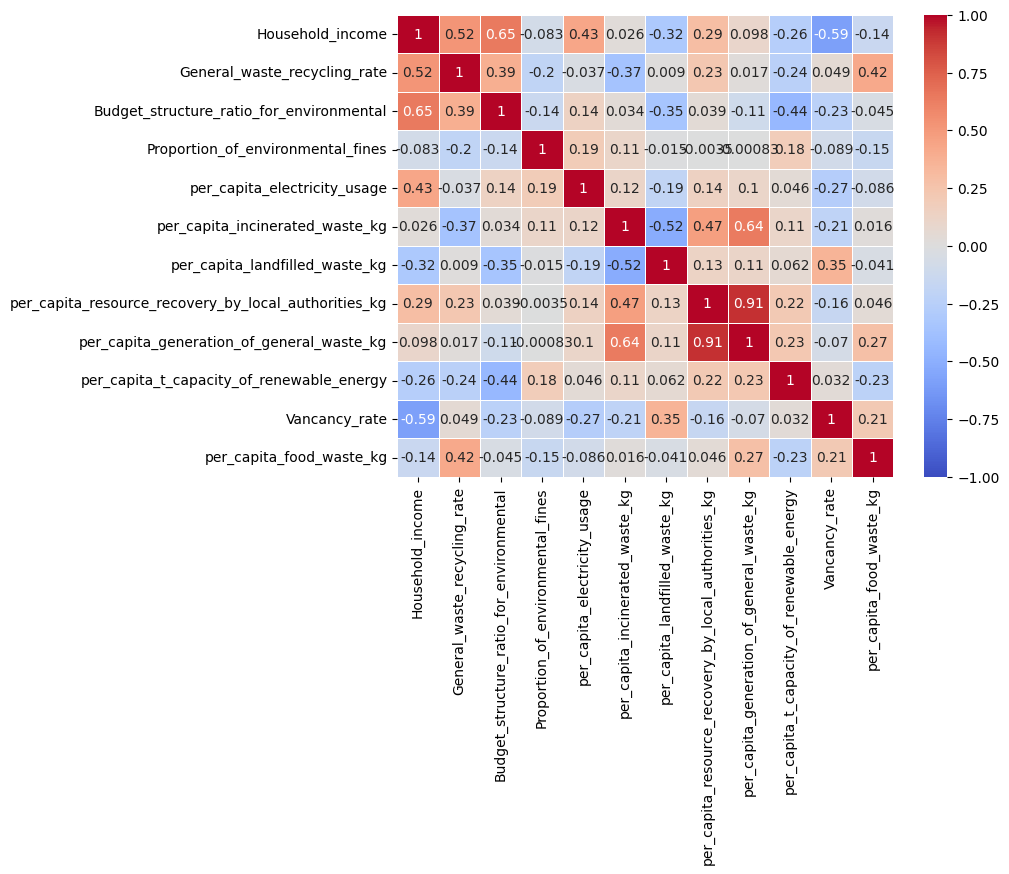

In [3]:
plt.figure(figsize=(8, 6))
sb.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.show()

##VIF 

In [4]:
# 假設 df_sub 是你要計算 VIF 的資料框（只包含數值欄位）

# 1. 加上截距項（常數）以符合 VIF 要求
X = df_sub.copy()
X['Intercept'] = 1
X = X.fillna(0)

# 2. 計算每個變數的 VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                                              feature          VIF
0                                    Household_income     4.487273
1                        General_waste_recycling_rate    13.487823
2            Budget_structure_ratio_for_environmental     2.088600
3                   Proportion_of_environmental_fines     1.165033
4                        per_capita_electricity_usage     1.419635
5                     per_capita_incinerated_waste_kg     5.812046
6                      per_capita_landfilled_waste_kg     2.313857
7   per_capita_resource_recovery_by_local_authorit...    86.060104
8           per_capita_generation_of_general_waste_kg   100.396789
9           per_capita_t_capacity_of_renewable_energy     1.637670
10                                      Vancancy_rate     2.462420
11                           per_capita_food_waste_kg    15.966115
12                                          Intercept  1132.153712


/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/linearmodels/panel/model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                                         Model Comparison                                         
                                                                Fixed Effects       Random Effects
--------------------------------------------------------------------------------------------------
Dep. Variable                                                Household_income     Household_income
Estimator                                                            PanelOLS        RandomEffects
No. Observations                                                          136                  136
Cov. Est.                                                          Unadjusted           Unadjusted
R-squared                                                              0.5755               0.5269
R-Squared (Within)                                                     0.5755               0.5754
R-Squared (Between)                                                -7.664e-05               0.0008
R-Squared 

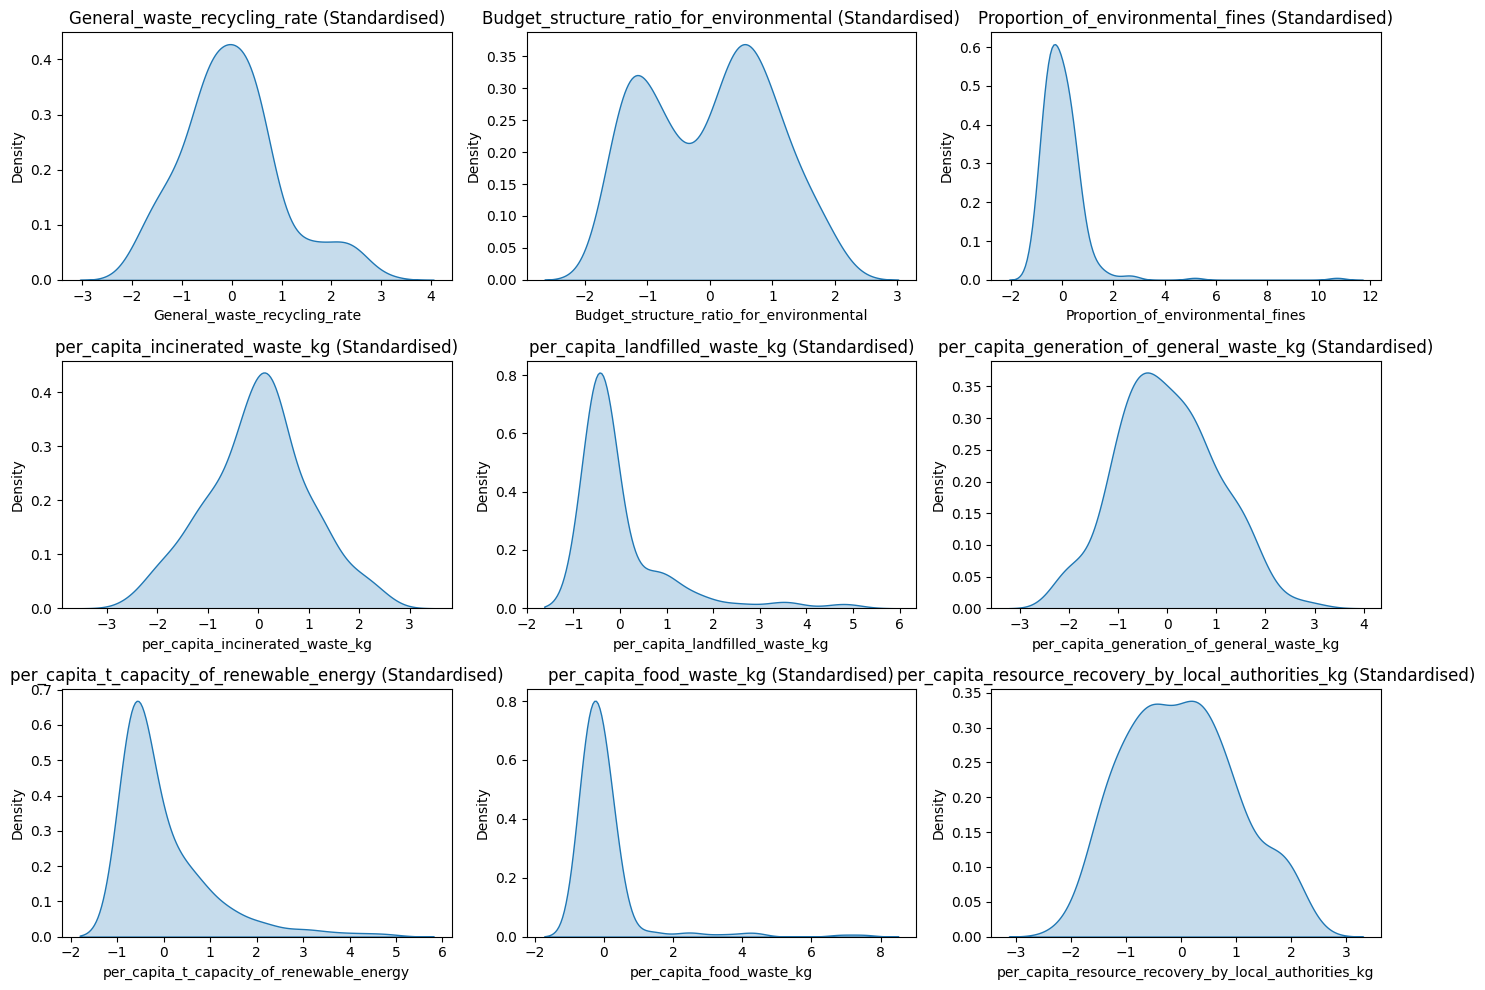

In [11]:
from linearmodels.panel import PanelOLS, RandomEffects, compare
from sklearn.preprocessing import StandardScaler
vars = ['General_waste_recycling_rate', 'Budget_structure_ratio_for_environmental', 'Proportion_of_environmental_fines', 'per_capita_incinerated_waste_kg',
        'per_capita_landfilled_waste_kg', 'per_capita_generation_of_general_waste_kg','per_capita_t_capacity_of_renewable_energy','per_capita_food_waste_kg','per_capita_resource_recovery_by_local_authorities_kg']  
# 假設你的資料框名為 panel_data，已經設置了 (city, year) 作為 MultiIndex
# 固定效應模型（固定效應(entity) = city）
# 先 reset index，才能轉換 year
df_cp = df.copy()
df_cp = df_cp.reset_index()
df_cp['year'] = pd.to_numeric(df_cp['year'], errors='coerce')  # 安全轉換為數字
df_cp = df_cp.set_index(['city/county', 'year'])  # 再設回 multi-index


# 創建 StandardScaler 物件
scaler = StandardScaler()

# 使用 .fit_transform() 來對數據進行標準化
df_cp[vars] = scaler.fit_transform(df_cp[vars])
#### Household_income
formula = 'Household_income ~ ' + ' + '.join(vars) + ' + EntityEffects'
model_fe = PanelOLS.from_formula(formula, data=df_cp)
fe_results = model_fe.fit()
# 隨機效應模型
formula = 'Household_income ~ ' + ' + '.join(vars) 
model_re = RandomEffects.from_formula(formula, data=df_cp)
re_results = model_re.fit()
# Hausman Test
result = compare({'Fixed Effects': fe_results, 'Random Effects': re_results})
print(result)

def calculate_hausman_test(fe_results, re_results):
    """
    從已有的固定效應和隨機效應模型結果計算Hausman測試統計量
    
    參數:
    fe_results: 固定效應模型結果對象
    re_results: 隨機效應模型結果對象
    
    返回:
    hausman_stat: Hausman測試統計量
    p_value: 對應的p值
    conclusion: 基於p值的結論
    """
    # 提取係數
    # 注意：排除常數項，只使用解釋變量的係數
    b_fe = fe_results.params
    b_re = re_results.params
    
    # 確保兩個模型有相同的變量集合
    common_vars = b_fe.index.intersection(b_re.index)
    b_fe = b_fe.loc[common_vars]
    b_re = b_re.loc[common_vars]
    
    # 計算係數差異
    diff = b_fe - b_re
    
    # 提取協方差矩陣
    var_fe = fe_results.cov.loc[common_vars, common_vars]
    var_re = re_results.cov.loc[common_vars, common_vars]
    
    # 計算協方差差異
    var_diff = var_fe - var_re
    
    # 計算Hausman統計量
    try:
        # 嘗試使用標準方法
        hausman_stat = diff.T @ np.linalg.inv(var_diff) @ diff
    except np.linalg.LinAlgError:
        # 如果矩陣不可逆，使用廣義逆
        hausman_stat = diff.T @ np.linalg.pinv(var_diff) @ diff
    
    # 自由度等於參數數量
    df = len(common_vars)
    
    # 計算p值（基於卡方分佈）
    p_value = 1 - scipy.stats.chi2.cdf(hausman_stat, df)
    
    # 判斷結果
    if p_value < 0.05:
        conclusion = "拒絕原假設，應使用固定效應模型"
    else:
        conclusion = "不能拒絕原假設，可以使用隨機效應模型"
    
    return hausman_stat, p_value, conclusion

# 假設您已經有了fe_results和re_results，例如：
# from linearmodels.panel import PanelOLS, RandomEffects
# fe_model = PanelOLS.from_formula('Household_income ~ General_waste_recycling_rate + Budget_structure_ratio_for_environmental + ...', data=panel_data, entity_effects=True)
# fe_results = fe_model.fit()
# re_model = RandomEffects.from_formula('Household_income ~ General_waste_recycling_rate + Budget_structure_ratio_for_environmental + ...', data=panel_data)
# re_results = re_model.fit()

# 計算Hausman測試統計量
hausman_stat, p_value, conclusion = calculate_hausman_test(fe_results, re_results)

print(f"Hausman測試統計量: {hausman_stat:.4f}")
print(f"P值: {p_value:.4f}")
print(f"結論: {conclusion}")

# 如果您想創建一個更詳細的結果表格
hausman_results = pd.DataFrame({
    '統計量': [hausman_stat],
    'P值': [p_value],
    '自由度': [len(fe_results.params)],
    '結論': [conclusion]
})

print("\nHausman測試結果:")
print(hausman_results)


df_std = pd.DataFrame(df_cp[vars], columns=vars)
df_std = df_std.reset_index()

plt.figure(figsize=(14, 10))
for i, var in enumerate(vars):
    plt.subplot(3, 3, i+1)
    sb.kdeplot(df_std[var], fill=True)
    plt.title(f'{var} (Standardised)')
plt.tight_layout()
plt.show()


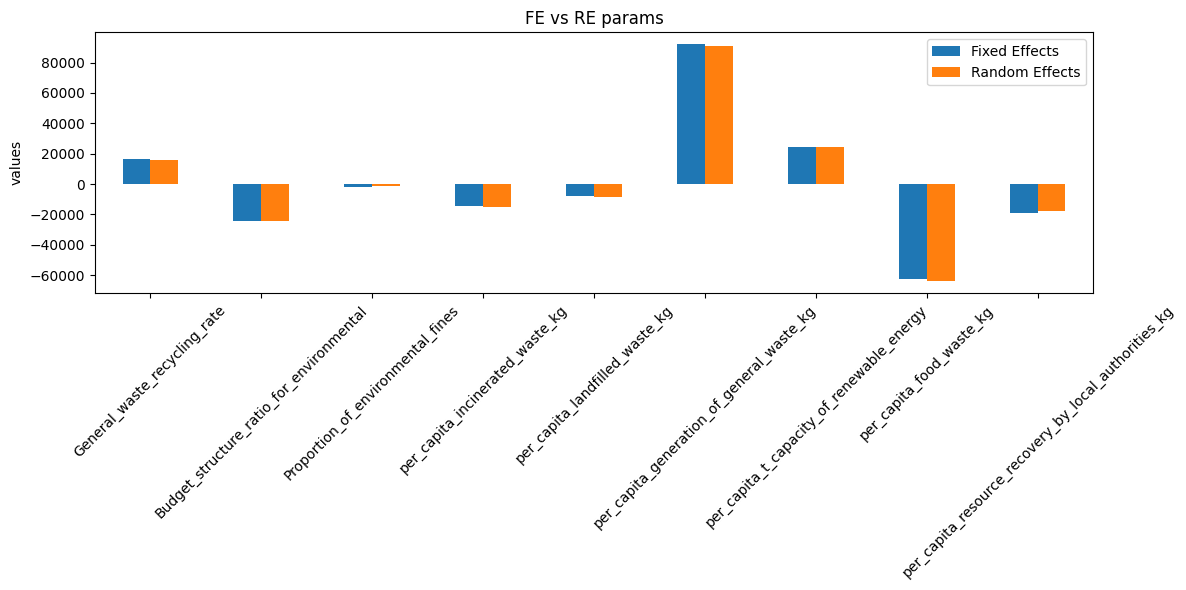

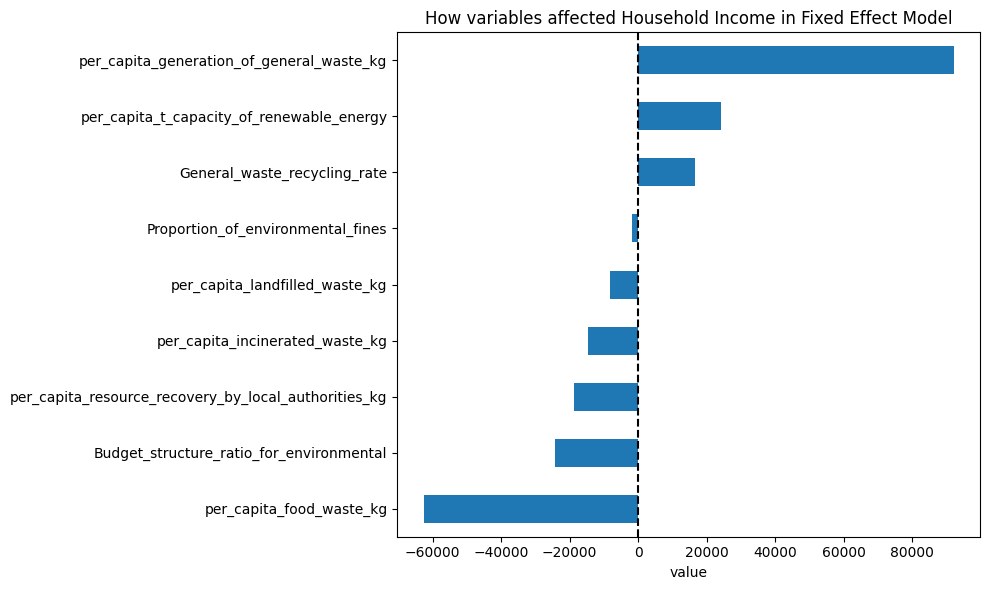

In [16]:
coef_df = pd.DataFrame({
    'Fixed Effects': fe_results.params,
    'Random Effects': re_results.params
}).dropna()

coef_df.plot(kind='bar', figsize=(12, 6))
plt.title("FE vs RE params")
plt.ylabel("values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


fe_results.params.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("How variables affected Household Income in Fixed Effect Model")
plt.xlabel("value")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()



                                                     Model Comparison                                                     
                                                                            Fixed Effects                   Random Effects
--------------------------------------------------------------------------------------------------------------------------
Dep. Variable                                                per_capita_electricity_usage     per_capita_electricity_usage
Estimator                                                                        PanelOLS                    RandomEffects
No. Observations                                                                      147                              147
Cov. Est.                                                                      Unadjusted                       Unadjusted
R-squared                                                                          0.0538                           0.0430
R-Squared (Withi

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/linearmodels/panel/model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


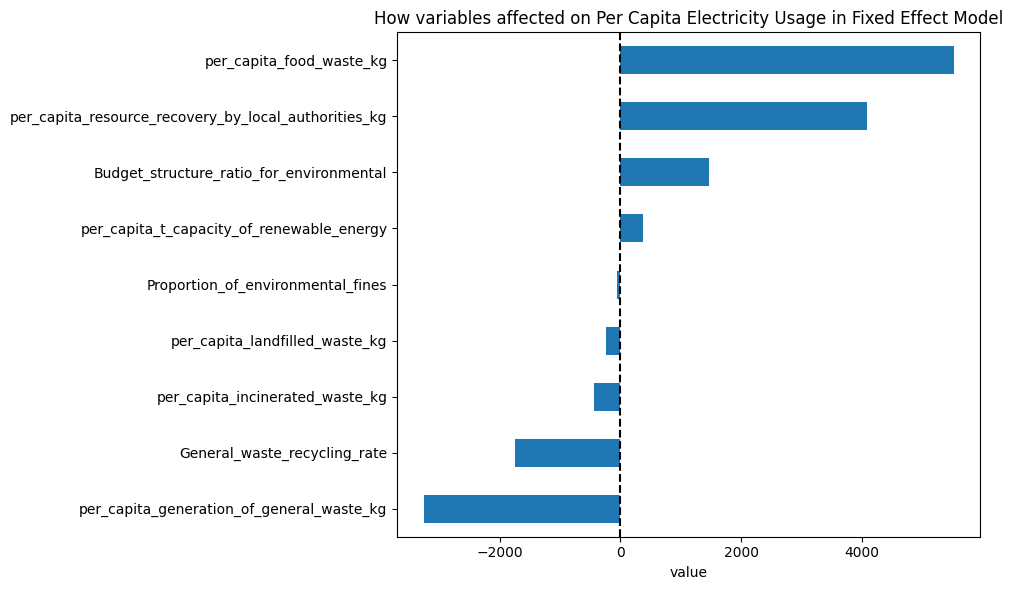

In [19]:
#### per_capita_electricity_usage
formula = 'per_capita_electricity_usage ~ ' + ' + '.join(vars) + ' + EntityEffects'
model_fe = PanelOLS.from_formula(formula, data=df_cp)
fe_results_2 = model_fe.fit()
# 隨機效應模型
formula = 'per_capita_electricity_usage ~ ' + ' + '.join(vars) 
model_re = RandomEffects.from_formula(formula, data=df_cp)
re_results_2 = model_re.fit()
# Hausman Test
hausman_test_2 = compare({'Fixed Effects': fe_results_2, 'Random Effects': re_results_2})

print(hausman_test_2)
# 計算Hausman測試統計量
hausman_stat, p_value, conclusion = calculate_hausman_test(fe_results_2, re_results_2)

print(f"Hausman測試統計量: {hausman_stat:.4f}")
print(f"P值: {p_value:.4f}")
print(f"結論: {conclusion}")

# 如果您想創建一個更詳細的結果表格
hausman_results = pd.DataFrame({
    '統計量': [hausman_stat],
    'P值': [p_value],
    '自由度': [len(fe_results.params)],
    '結論': [conclusion]
})

print("\nHausman測試結果:")
print(hausman_results)

fe_results_2.params.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("How variables affected on Per Capita Electricity Usage in Fixed Effect Model")
plt.xlabel("value")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

                                      Model Comparison                                      
                                                             Fixed Effects    Random Effects
--------------------------------------------------------------------------------------------
Dep. Variable                                                Vancancy_rate     Vancancy_rate
Estimator                                                         PanelOLS     RandomEffects
No. Observations                                                       147               147
Cov. Est.                                                       Unadjusted        Unadjusted
R-squared                                                           0.3796            0.3371
R-Squared (Within)                                                  0.3796            0.3795
R-Squared (Between)                                                 0.0117            0.0125
R-Squared (Overall)                                                -0.

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/linearmodels/panel/model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


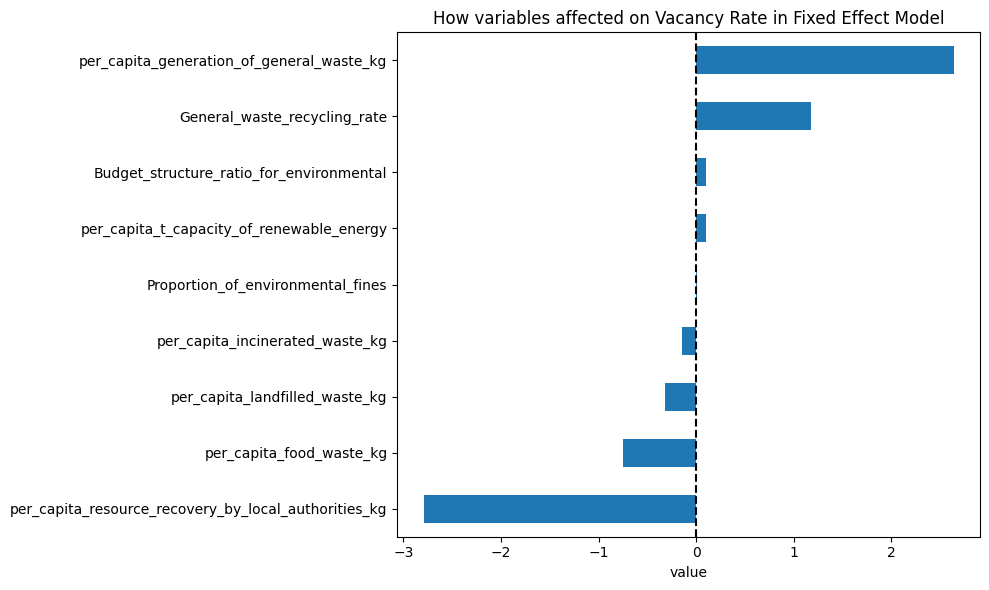

In [21]:
#### Vancancy_rate
formula = 'Vancancy_rate ~ ' + ' + '.join(vars) + ' + EntityEffects'
model_fe = PanelOLS.from_formula(formula, data=df_cp)
fe_results_3 = model_fe.fit()
# 隨機效應模型
formula = 'Vancancy_rate ~ ' + ' + '.join(vars) 
model_re = RandomEffects.from_formula(formula, data=df_cp)
re_results_3 = model_re.fit()
# Hausman Test
hausman_test_3 = compare({'Fixed Effects': fe_results_3, 'Random Effects': re_results_3})
print(hausman_test_3)
# 計算Hausman測試統計量
hausman_stat, p_value, conclusion = calculate_hausman_test(fe_results_3, re_results_3)

print(f"Hausman測試統計量: {hausman_stat:.4f}")
print(f"P值: {p_value:.4f}")
print(f"結論: {conclusion}")

# 如果您想創建一個更詳細的結果表格
hausman_results = pd.DataFrame({
    '統計量': [hausman_stat],
    'P值': [p_value],
    '自由度': [len(fe_results.params)],
    '結論': [conclusion]
})

print("\nHausman測試結果:")
print(hausman_results)


fe_results_3.params.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("How variables affected on Vacancy Rate in Fixed Effect Model")
plt.xlabel("value")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

## NonLinear Regression 


In [3]:
### Household income


from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from pygam import LinearGAM, s
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# 複製資料框
df_mean = df.copy()

# 找出所有數值型欄位
numeric_cols = df_mean.select_dtypes(include=[np.number]).columns.tolist()

# 對每個數值型欄位應用分組平均值填充
for col in numeric_cols:
    df_mean[col] = df_mean.groupby('city/county')[col].transform(
            lambda x: x.fillna(x.mean()))
# 處理仍然有 NA 的值 (可能是某些組沒有任何值)
for col in numeric_cols:
    df_mean[col] = df_mean[col].fillna(df_mean[col].mean())




print(df_mean)
y = df_mean["Household_income"]
X = df_mean[vars].copy()

##########


pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm.SVR(kernel='rbf', C=1, gamma='auto'))  
])
pipeline_xg = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        n_estimators=200,        # 樹的數量
        max_depth=6,             # 樹的最大深度
        learning_rate=0.05,      # 學習率
        subsample=0.8,           # 隨機抽樣
        colsample_bytree=0.8,    # 每棵樹的隨機特徵子集
        random_state=42          # 隨機種子
    ))
])
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=1200, random_state=42,min_samples_leaf=2, 
                                 min_samples_split=2))
])


pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42))
])

pipeline_cat = Pipeline([
    ('scaler', StandardScaler()),
    ('cat', CatBoostRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42, verbose=0))
])



# R^2 
#scores_svm = cross_val_score(pipeline_svm, X, y, cv=10, scoring='r2')  
scores_xgb = cross_val_score(pipeline_xg, X, y, cv=10, scoring='r2')
scores_rf = cross_val_score(pipeline_rf, X, y, cv=10, scoring='r2')
scores_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=10, scoring='r2')
scores_cat = cross_val_score(pipeline_cat, X, y, cv=10, scoring='r2')
#print("SVM R²：", scores_svm.mean())
print("XGB R²：", scores_xgb.mean())
print("RF R²：", scores_rf.mean())
print("LightGBM R²:", scores_lgbm.mean())
print("CatBoost R²:", scores_cat.mean())
## find importance


# 先 fit 四個模型
pipeline_xg.fit(X, y)
pipeline_rf.fit(X, y)
pipeline_lgbm.fit(X, y)
pipeline_cat.fit(X, y)

# 拿出內部模型
xgb_model = pipeline_xg.named_steps['xgb']
rf_model = pipeline_rf.named_steps['rf']
lgbm_model = pipeline_lgbm.named_steps['lgbm']
cat_model = pipeline_cat.named_steps['cat']

# 抓 feature importance
feature_names = X.columns

xgb_importance = xgb_model.feature_importances_
rf_importance = rf_model.feature_importances_
lgbm_importance = lgbm_model.feature_importances_
cat_importance = cat_model.feature_importances_

# 整理成 DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': xgb_importance,
    'Random Forest': rf_importance,
    'LightGBM': lgbm_importance,
    'CatBoost': cat_importance
})

# 加一個平均值
importance_df['Mean'] = importance_df[['XGBoost', 'Random Forest', 'LightGBM', 'CatBoost']].mean(axis=1)

# 排序，找出 Top 10
importance_df = importance_df.sort_values(by='Mean', ascending=False)
top10 = importance_df.head(10)
'''
# 畫圖
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
bar_width = 0.7
index = np.arange(len(top10))

plt.barh(index, top10['Mean'], bar_width, color='skyblue')

plt.yticks(index, top10['Feature'])
plt.xlabel('Average Importance')
plt.title('Top 10 Important Features for Predicting Household Income')
plt.gca().invert_yaxis()  # 讓最重要的在最上面
plt.tight_layout()
plt.show()
'''


'''
######
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.18
index = np.arange(len(top10))

# 每一組 bar 往右位移一點
plt.barh(index - 0.5*bar_width, top10['CatBoost'], bar_width, label='CatBoost', color='lightgreen')


# 標籤、格式
plt.yticks(index, top10['Feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Comparison Across Models (Top 10 Features)')
plt.legend()
plt.gca().invert_yaxis()  # 重要特徵放上面
plt.tight_layout()
plt.show()
'''

     year city/county  Household_income  General_waste_recycling_rate  \
0    2014         南投縣         919551.00                         51.73   
1    2014         嘉義市        1157962.00                         57.96   
2    2014         嘉義縣         789406.00                         47.39   
3    2014         基隆市         957360.00                         54.63   
4    2014         宜蘭縣        1071335.00                         60.80   
..    ...         ...               ...                           ...   
215  2023         苗栗縣        1341195.00                         49.40   
216  2023         連江縣        1158675.47                         54.38   
217  2023         金門縣        1158675.47                         74.74   
218  2023         雲林縣        1087755.00                         54.28   
219  2023         高雄市        1325786.00                         61.37   

     Budget_structure_ratio_for_environmental  \
0                                        1.17   
1                        

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 secon

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


XGB R²： 0.7202461483089467
RF R²： 0.6877685891506544
LightGBM R²: 0.6990294132199455
CatBoost R²: 0.7517862910091488
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 9
[LightGBM] [Info] Start training from score 1158675.472727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

"\n######\nfig, ax = plt.subplots(figsize=(14, 8))\n\nbar_width = 0.18\nindex = np.arange(len(top10))\n\n# 每一組 bar 往右位移一點\nplt.barh(index - 0.5*bar_width, top10['CatBoost'], bar_width, label='CatBoost', color='lightgreen')\n\n\n# 標籤、格式\nplt.yticks(index, top10['Feature'])\nplt.xlabel('Feature Importance')\nplt.title('Feature Importance Comparison Across Models (Top 10 Features)')\nplt.legend()\nplt.gca().invert_yaxis()  # 重要特徵放上面\nplt.tight_layout()\nplt.show()\n"

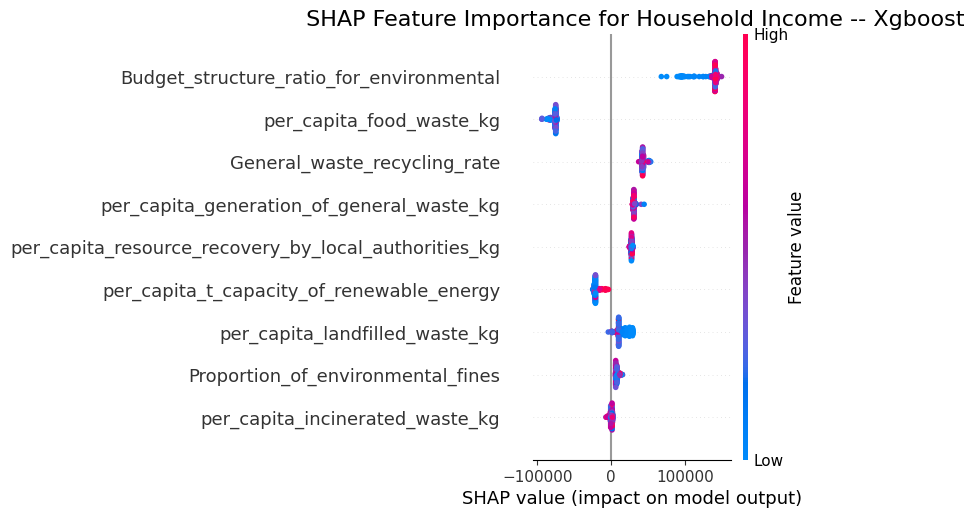

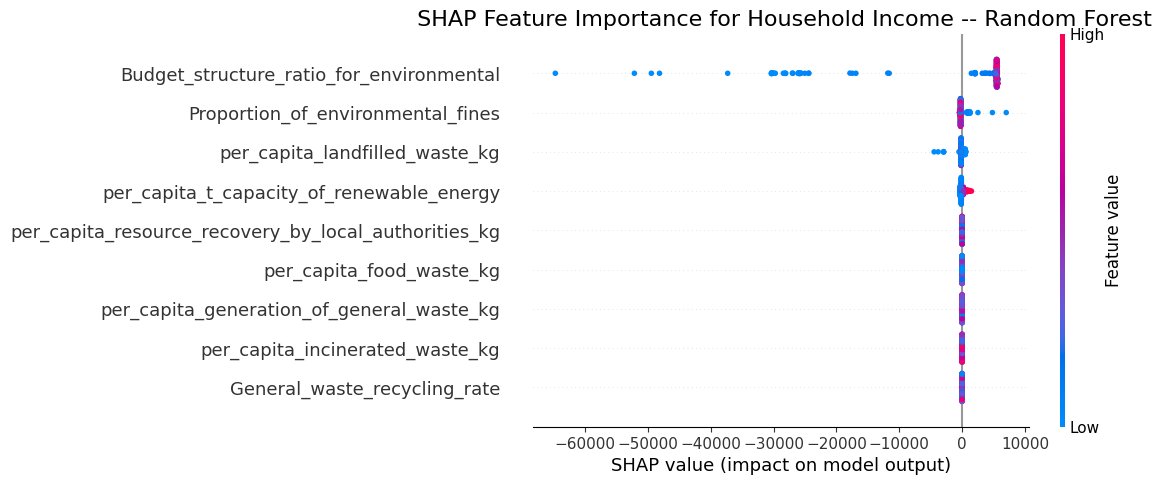

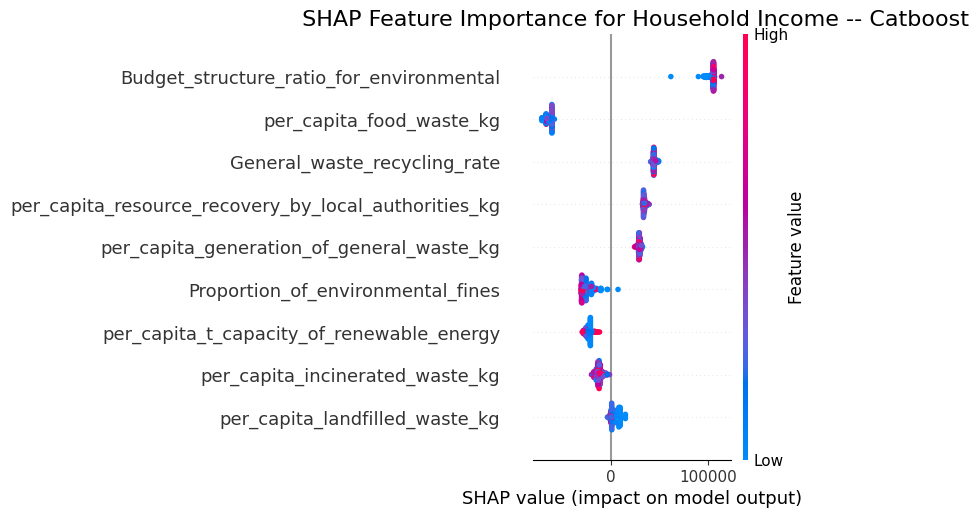

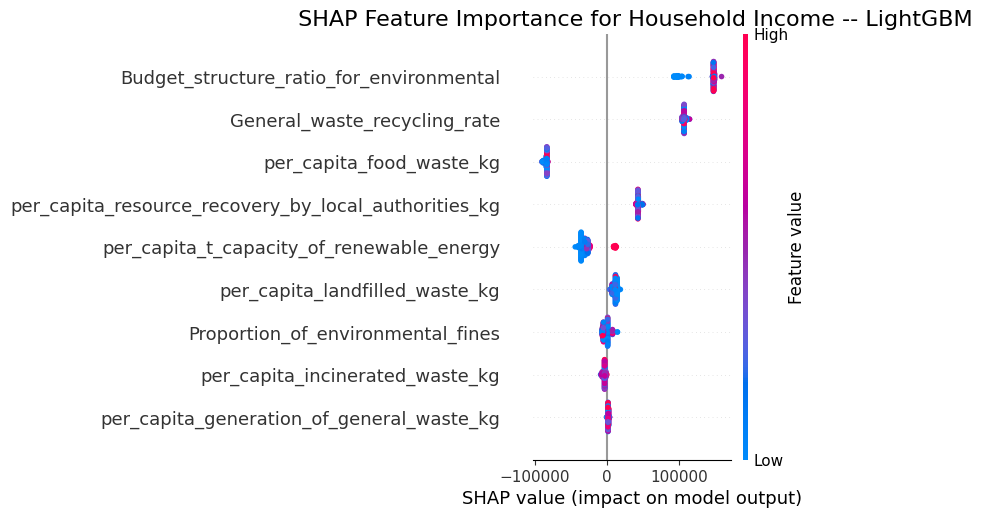

In [22]:
### shap value test--- income 

import shap

xgb_model = pipeline_xg.named_steps['xgb']
rf_model = pipeline_rf.named_steps['rf']
lgbm_model = pipeline_lgbm.named_steps['lgbm']
cat_model = pipeline_cat.named_steps['cat']


explainer2 = shap.TreeExplainer(rf_model, X)  # rf_model 是你訓練過的 Random Forest
shap_values2 = explainer2(X)

# 1. 準備 SHAP explainer
explainer1 = shap.TreeExplainer(xgb_model)  # 這裡用 XGBoost 訓練好的模型
explainer3 = shap.TreeExplainer(cat_model)
explainer4 = shap.TreeExplainer(lgbm_model)
# 2. 計算 shap value
shap_values1 = explainer1.shap_values(X)
shap_values3 = explainer3.shap_values(X)
shap_values4 = explainer4.shap_values(X)

# plotting
shap.summary_plot(shap_values1, X, show =False)
plt.title(" SHAP Feature Importance for Household Income -- Xgboost", fontsize=16)
plt.show()

shap.plots.beeswarm(shap_values2, show= False)
plt.title(" SHAP Feature Importance for Household Income -- Random Forest", fontsize=16)
plt.show()

shap.summary_plot(shap_values3, X, show =False)
plt.title(" SHAP Feature Importance for Household Income -- Catboost", fontsize=16)
plt.show()

shap.summary_plot(shap_values4, X, show =False)
plt.title(" SHAP Feature Importance for Household Income -- LightGBM", fontsize=16)
plt.show()


#### Shap values do not consist with feature importance above is normal HAHHAHAH

In [9]:
# 1. 准备 SHAP explainer
explainer1 = shap.TreeExplainer(xgb_model)  # XGBoost
explainer2 = shap.TreeExplainer(rf_model)   # Random Forest
explainer3 = shap.TreeExplainer(cat_model)  # CatBoost
explainer4 = shap.TreeExplainer(lgbm_model) # LightGBM

# 2. 计算 SHAP 值并统一转换为 numpy 数组
def get_shap_values(explainer, X):
    shap_values = explainer.shap_values(X)
    # 处理不同返回类型
    if isinstance(shap_values, list):
        # 分类问题会返回列表，取第一个元素
        return np.array(shap_values[0]) if len(shap_values) == 2 else np.array(shap_values)
    elif hasattr(shap_values, 'values'):
        return shap_values.values
    else:
        return np.array(shap_values)

shap_values1 = get_shap_values(explainer1, X)
shap_values2 = get_shap_values(explainer2, X)
shap_values3 = get_shap_values(explainer3, X)
shap_values4 = get_shap_values(explainer4, X)

# 3. 提取SHAP值到DataFrame
shap_df = pd.DataFrame({
    "feature": X.columns,
    "shap_avg_xgb": shap_values1.mean(axis=0),
    "shap_std_xgb": shap_values1.std(axis=0),
    "shap_avg_rf": shap_values2.mean(axis=0),
    "shap_std_rf": shap_values2.std(axis=0),
    "shap_avg_cat": shap_values3.mean(axis=0),
    "shap_std_cat": shap_values3.std(axis=0),
    "shap_avg_lgbm": shap_values4.mean(axis=0),
    "shap_std_lgbm": shap_values4.std(axis=0),
}).sort_values("shap_avg_xgb", ascending=False)

print("SHAP值摘要：\n", shap_df)

SHAP值摘要：
                                              feature   shap_avg_xgb  \
1           Budget_structure_ratio_for_environmental  135392.453125   
0                       General_waste_recycling_rate   43612.730469   
5          per_capita_generation_of_general_waste_kg   30846.835938   
8  per_capita_resource_recovery_by_local_authorit...   27689.310547   
4                     per_capita_landfilled_waste_kg   16089.567383   
2                  Proportion_of_environmental_fines    8109.053223   
3                    per_capita_incinerated_waste_kg     297.502441   
6          per_capita_t_capacity_of_renewable_energy  -20539.074219   
7                           per_capita_food_waste_kg  -76819.507812   

   shap_std_xgb    shap_avg_rf   shap_std_rf   shap_avg_cat  shap_std_cat  \
1  15245.246094  184066.051401  15263.587236  103777.675822   3881.664085   
0   3076.495361   56781.398581   3103.862214   44103.875429   1147.334919   
5   1489.205688   11151.594753    289.698279   2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 9
[LightGBM] [Info] Start training from score 8689.656397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 9
[LightGBM] [Info] Start training from score 8918.848792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


SVM R²： -0.12599030980790715
XGB R²： 0.42738934775487136
RF R²： 0.47891443424073243
LightGBM R²: 0.4742846873583015
CatBoost R²: 0.4195937238729025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 9
[LightGBM] [Info] Start training from score 8842.382424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

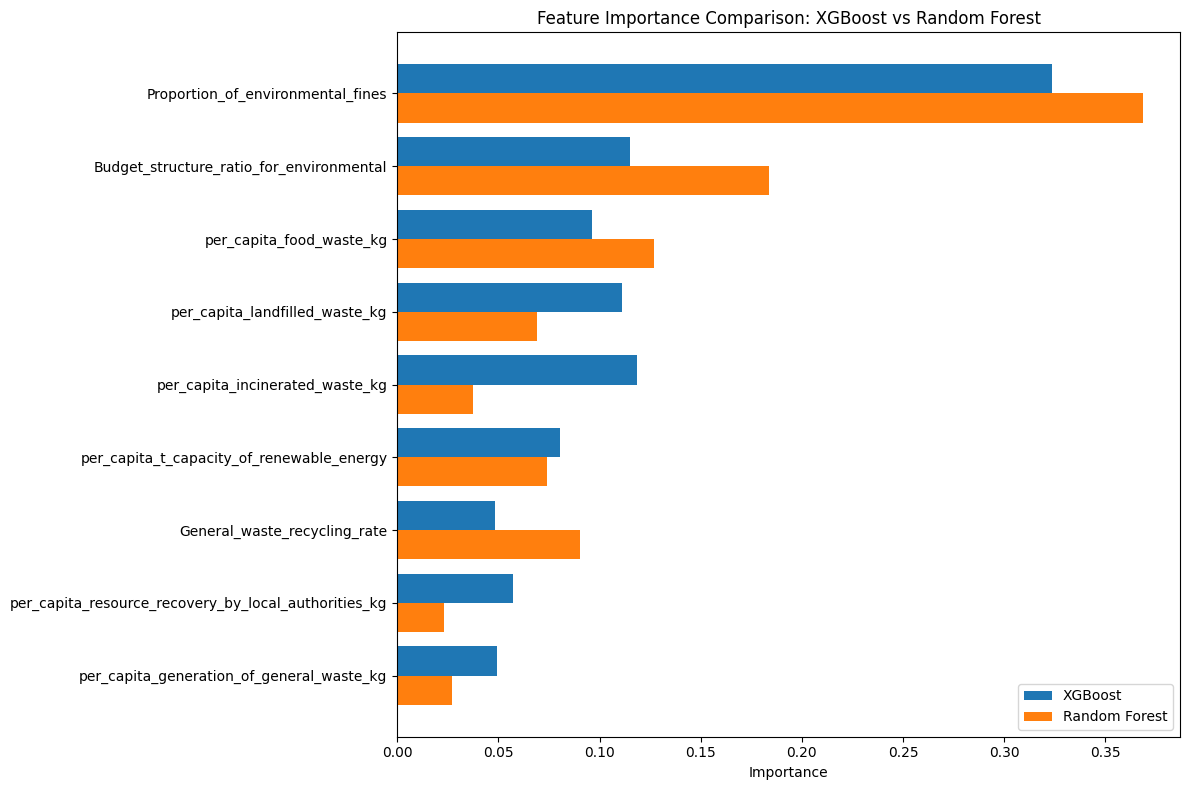

In [23]:
df_cp2_non_missing = df_mean[df_mean["per_capita_electricity_usage"].notnull()]
X = df_cp2_non_missing[vars]
y = df_cp2_non_missing["per_capita_electricity_usage"]

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm.SVR(kernel='rbf', C=1, gamma='auto'))  
])
pipeline_xg = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        n_estimators=200,        # 樹的數量
        max_depth=6,             # 樹的最大深度
        learning_rate=0.05,      # 學習率
        subsample=0.8,           # 隨機抽樣
        colsample_bytree=0.8,    # 每棵樹的隨機特徵子集
        random_state=42          # 隨機種子
    ))
])
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=1200, random_state=42,min_samples_leaf=2, 
                                 min_samples_split=2))
])


pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42))
])

pipeline_cat = Pipeline([
    ('scaler', StandardScaler()),
    ('cat', CatBoostRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42, verbose=0))
])



# R^2 
scores_svm = cross_val_score(pipeline_svm, X, y, cv=10, scoring='r2')  
scores_xgb = cross_val_score(pipeline_xg, X, y, cv=10, scoring='r2')
scores_rf = cross_val_score(pipeline_rf, X, y, cv=10, scoring='r2')
scores_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=10, scoring='r2')
scores_cat = cross_val_score(pipeline_cat, X, y, cv=10, scoring='r2')
print("SVM R²：", scores_svm.mean())
print("XGB R²：", scores_xgb.mean())
print("RF R²：", scores_rf.mean())
print("LightGBM R²:", scores_lgbm.mean())
print("CatBoost R²:", scores_cat.mean())

## find importance
# 確保兩個模型都已經 fit 完
pipeline_xg.fit(X, y)
pipeline_rf.fit(X, y)
pipeline_cat.fit(X,y)
pipeline_lgbm.fit(X,y)

xgb_model = pipeline_xg.named_steps['xgb']
rf_model = pipeline_rf.named_steps['rf']

feature_names = X.columns

xgb_importance = xgb_model.feature_importances_
rf_importance = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': xgb_importance,
    'Random Forest': rf_importance
})
importance_df['Mean'] = (importance_df['XGBoost'] + importance_df['Random Forest']) / 2
importance_df = importance_df.sort_values(by='Mean', ascending=False)

plt.figure(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(importance_df))

plt.barh(index, importance_df['XGBoost'], bar_width, label='XGBoost')
plt.barh(index + bar_width, importance_df['Random Forest'], bar_width, label='Random Forest')

plt.yticks(index + bar_width / 2, importance_df['Feature'])
plt.xlabel('Importance')
plt.title('Feature Importance Comparison: XGBoost vs Random Forest')
plt.legend()
plt.gca().invert_yaxis()  # 讓最重要的在最上面
plt.tight_layout()
plt.show()


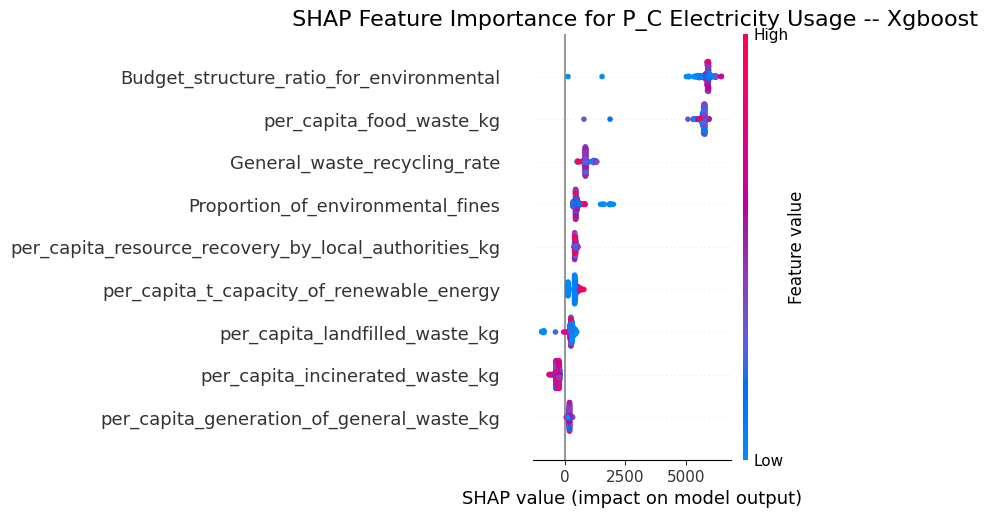

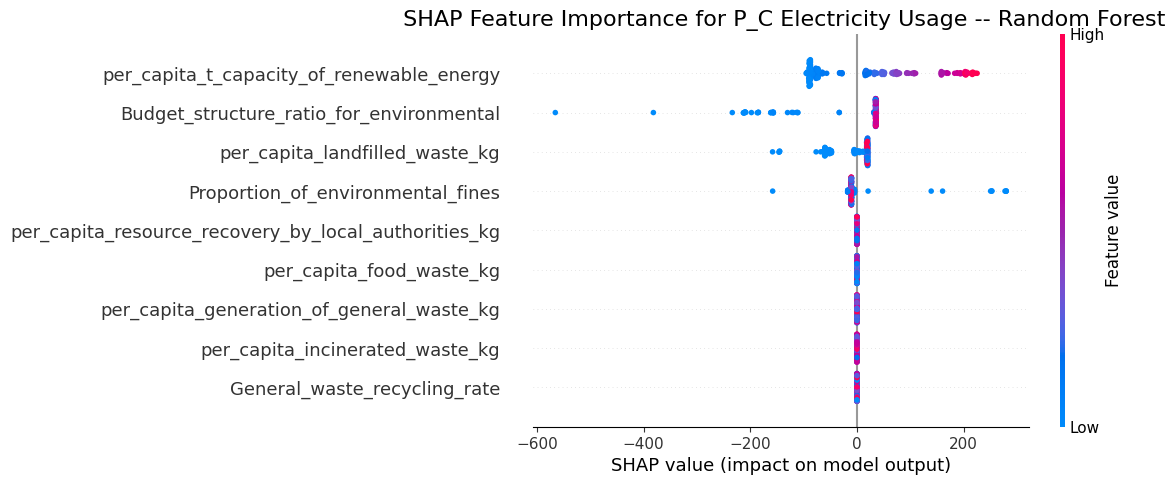

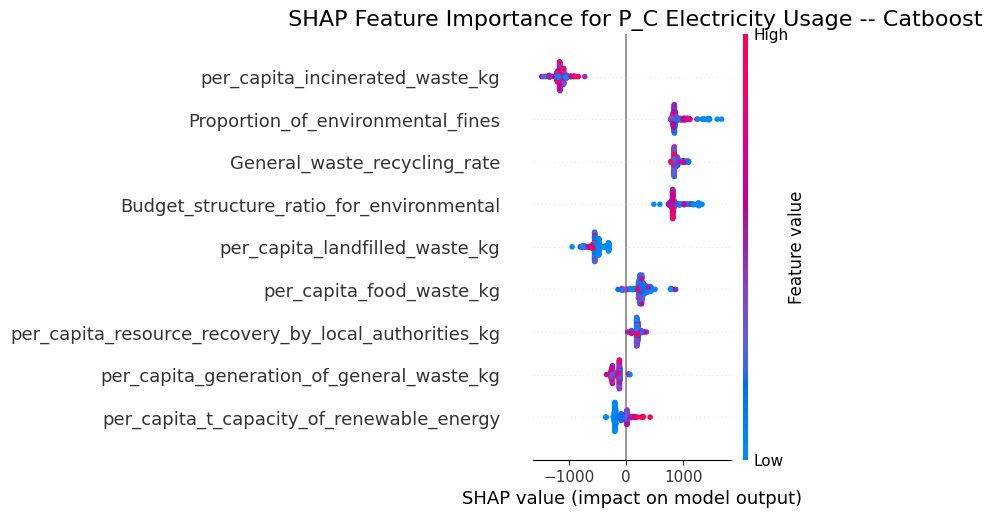

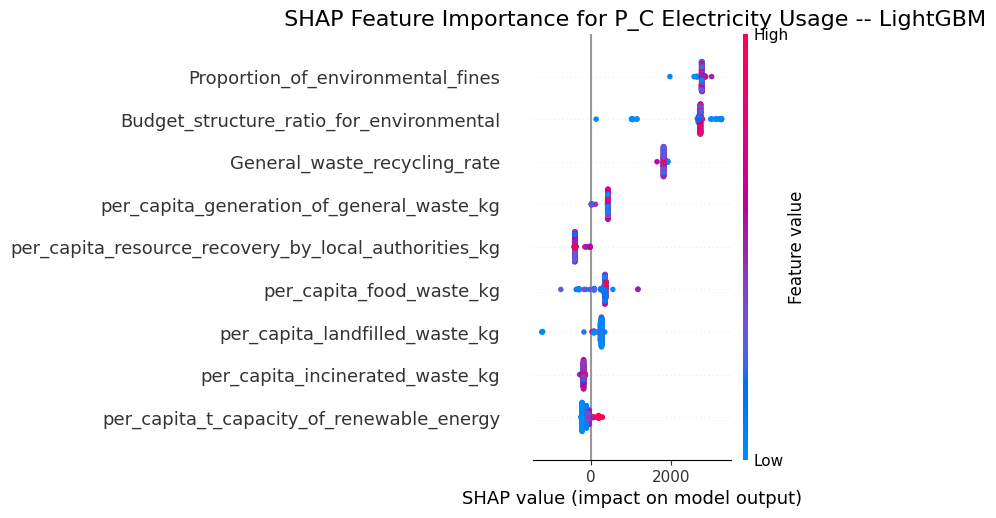

In [25]:
### shap value test--- income 

import shap

xgb_model = pipeline_xg.named_steps['xgb']
rf_model = pipeline_rf.named_steps['rf']
lgbm_model = pipeline_lgbm.named_steps['lgbm']
cat_model = pipeline_cat.named_steps['cat']


explainer2 = shap.TreeExplainer(rf_model, X)  # rf_model 是你訓練過的 Random Forest
shap_values2 = explainer2(X)

# 1. 準備 SHAP explainer
explainer1 = shap.TreeExplainer(xgb_model)  # 這裡用 XGBoost 訓練好的模型
explainer3 = shap.TreeExplainer(cat_model)
explainer4 = shap.TreeExplainer(lgbm_model)
# 2. 計算 shap value
shap_values1 = explainer1.shap_values(X)
shap_values3 = explainer3.shap_values(X)
shap_values4 = explainer4.shap_values(X)

# plotting
shap.summary_plot(shap_values1, X, show =False)
plt.title(" SHAP Feature Importance for P_C Electricity Usage -- Xgboost", fontsize=16)
plt.show()

shap.plots.beeswarm(shap_values2, show= False)
plt.title(" SHAP Feature Importance for P_C Electricity Usage -- Random Forest", fontsize=16)
plt.show()

shap.summary_plot(shap_values3, X, show =False)
plt.title(" SHAP Feature Importance for P_C Electricity Usage -- Catboost", fontsize=16)
plt.show()

shap.summary_plot(shap_values4, X, show =False)
plt.title(" SHAP Feature Importance for P_C Electricity Usage -- LightGBM", fontsize=16)
plt.show()


#### Shap values do not consist with feature importance above is normal HAHHAHAH

In [26]:
# 2. 计算 SHAP 值并统一转换为 numpy 数组
def get_shap_values(explainer, X):
    shap_values = explainer.shap_values(X)
    # 处理不同返回类型
    if isinstance(shap_values, list):
        # 分类问题会返回列表，取第一个元素
        return np.array(shap_values[0]) if len(shap_values) == 2 else np.array(shap_values)
    elif hasattr(shap_values, 'values'):
        return shap_values.values
    else:
        return np.array(shap_values)

shap_values1 = get_shap_values(explainer1, X)
shap_values2 = get_shap_values(explainer2, X)
shap_values3 = get_shap_values(explainer3, X)
shap_values4 = get_shap_values(explainer4, X)

# 3. 提取SHAP值到DataFrame
shap_df = pd.DataFrame({
    "feature": X.columns,
    "shap_avg_xgb": shap_values1.mean(axis=0),
    "shap_std_xgb": shap_values1.std(axis=0),
    "shap_avg_rf": shap_values2.mean(axis=0),
    "shap_std_rf": shap_values2.std(axis=0),
    "shap_avg_cat": shap_values3.mean(axis=0),
    "shap_std_cat": shap_values3.std(axis=0),
    "shap_avg_lgbm": shap_values4.mean(axis=0),
    "shap_std_lgbm": shap_values4.std(axis=0),
}).sort_values("shap_avg_xgb", ascending=False)

print("SHAP值摘要：\n", shap_df)

SHAP值摘要：
                                              feature  shap_avg_xgb  \
1           Budget_structure_ratio_for_environmental   5818.125488   
7                           per_capita_food_waste_kg   5680.306152   
0                       General_waste_recycling_rate    903.262939   
2                  Proportion_of_environmental_fines    552.189148   
8  per_capita_resource_recovery_by_local_authorit...    443.335724   
6          per_capita_t_capacity_of_renewable_energy    417.432861   
4                     per_capita_landfilled_waste_kg    247.317429   
5          per_capita_generation_of_general_waste_kg    189.828079   
3                    per_capita_incinerated_waste_kg   -282.862335   

   shap_std_xgb  shap_avg_rf  shap_std_rf  shap_avg_cat  shap_std_cat  \
1    519.062622     2.564907    85.075645    871.978169    137.001709   
7    430.980286     0.000000     0.000000    292.228163    128.203986   
0    152.535843     0.000000     0.000000    880.061159     61.478238 

In [27]:
df_cp2_non_missing = df_mean[df_mean["Vancancy_rate"].notnull()]

X = df_cp2_non_missing[vars]
y = df_cp2_non_missing["Vancancy_rate"]

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm.SVR(kernel='rbf', C=1, gamma='auto'))  
])
pipeline_xg = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        n_estimators=200,        # 樹的數量
        max_depth=6,             # 樹的最大深度
        learning_rate=0.05,      # 學習率
        subsample=0.8,           # 隨機抽樣
        colsample_bytree=0.8,    # 每棵樹的隨機特徵子集
        random_state=42          # 隨機種子
    ))
])
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=1200, random_state=42,min_samples_leaf=2, 
                                 min_samples_split=2))
])


pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42))
])

pipeline_cat = Pipeline([
    ('scaler', StandardScaler()),
    ('cat', CatBoostRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42, verbose=0))
])



# R^2 
scores_svm = cross_val_score(pipeline_svm, X, y, cv=10, scoring='r2')  
scores_xgb = cross_val_score(pipeline_xg, X, y, cv=10, scoring='r2')
scores_rf = cross_val_score(pipeline_rf, X, y, cv=10, scoring='r2')
scores_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=10, scoring='r2')
scores_cat = cross_val_score(pipeline_cat, X, y, cv=10, scoring='r2')
print("SVM R²：", scores_svm.mean())
print("XGB R²：", scores_xgb.mean())
print("RF R²：", scores_rf.mean())
print("LightGBM R²:", scores_lgbm.mean())
print("CatBoost R²:", scores_cat.mean())


## find importance
pipeline_xg.fit(X, y)
pipeline_rf.fit(X, y)
pipeline_cat.fit(X,y)
pipeline_lgbm.fit(X,y)
'''
xgb_model = pipeline_xg.named_steps['xgb']
rf_model = pipeline_rf.named_steps['rf']

feature_names = X.columns

xgb_importance = xgb_model.feature_importances_
rf_importance = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': xgb_importance,
    'Random Forest': rf_importance
})
importance_df['Mean'] = (importance_df['XGBoost'] + importance_df['Random Forest']) / 2
importance_df = importance_df.sort_values(by='Mean', ascending=False)

plt.figure(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(importance_df))

plt.barh(index, importance_df['XGBoost'], bar_width, label='XGBoost')
plt.barh(index + bar_width, importance_df['Random Forest'], bar_width, label='Random Forest')

plt.yticks(index + bar_width / 2, importance_df['Feature'])
plt.xlabel('Importance')
plt.title('Feature Importance Comparison: XGBoost vs Random Forest')
plt.legend()
plt.gca().invert_yaxis()  # 讓最重要的在最上面
plt.tight_layout()
plt.show()'''


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 9
[LightGBM] [Info] Start training from score 11.042323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/yuzetsai/Desktop/untitled folder/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


SVM R²： 0.33826884862135476
XGB R²： 0.7361745201545792
RF R²： 0.6589178406356307
LightGBM R²: 0.5963069060676645
CatBoost R²: 0.7425508377512842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 9
[LightGBM] [Info] Start training from score 11.033864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

"\nxgb_model = pipeline_xg.named_steps['xgb']\nrf_model = pipeline_rf.named_steps['rf']\n\nfeature_names = X.columns\n\nxgb_importance = xgb_model.feature_importances_\nrf_importance = rf_model.feature_importances_\n\nimportance_df = pd.DataFrame({\n    'Feature': feature_names,\n    'XGBoost': xgb_importance,\n    'Random Forest': rf_importance\n})\nimportance_df['Mean'] = (importance_df['XGBoost'] + importance_df['Random Forest']) / 2\nimportance_df = importance_df.sort_values(by='Mean', ascending=False)\n\nplt.figure(figsize=(12, 8))\nbar_width = 0.4\nindex = np.arange(len(importance_df))\n\nplt.barh(index, importance_df['XGBoost'], bar_width, label='XGBoost')\nplt.barh(index + bar_width, importance_df['Random Forest'], bar_width, label='Random Forest')\n\nplt.yticks(index + bar_width / 2, importance_df['Feature'])\nplt.xlabel('Importance')\nplt.title('Feature Importance Comparison: XGBoost vs Random Forest')\nplt.legend()\nplt.gca().invert_yaxis()  # 讓最重要的在最上面\nplt.tight_layout()\n

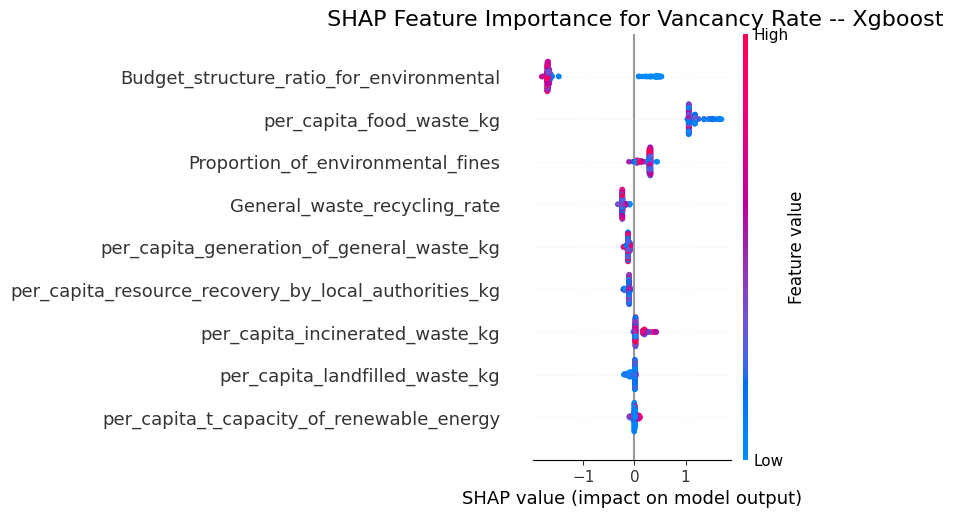

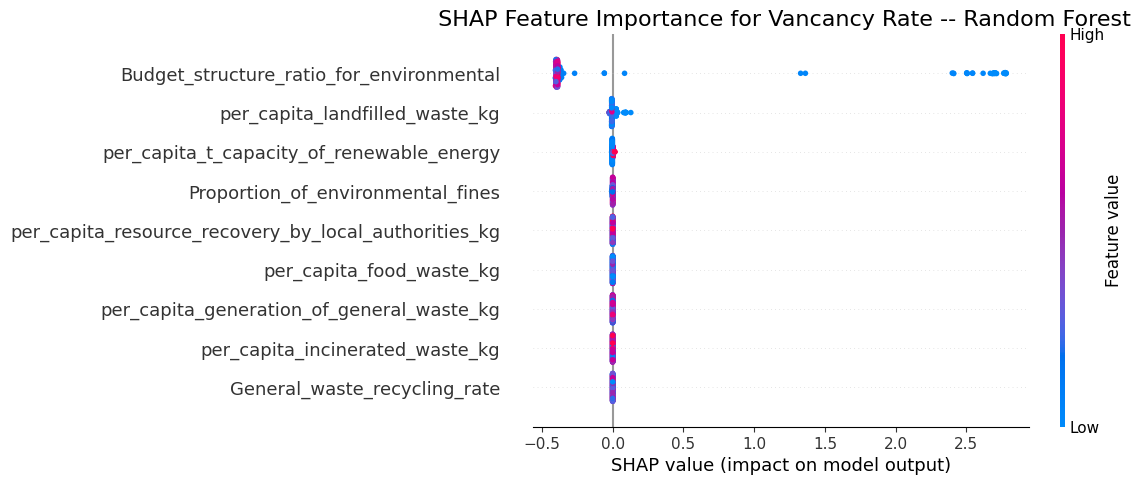

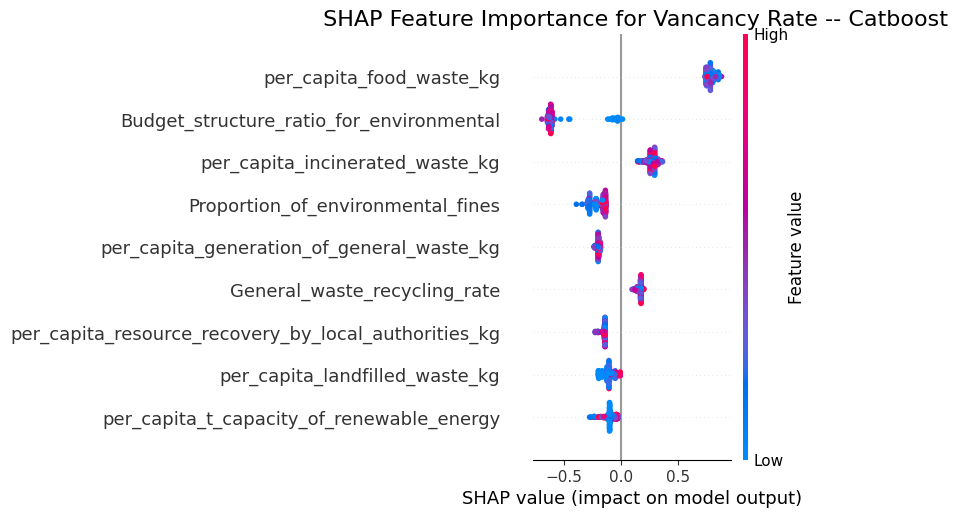

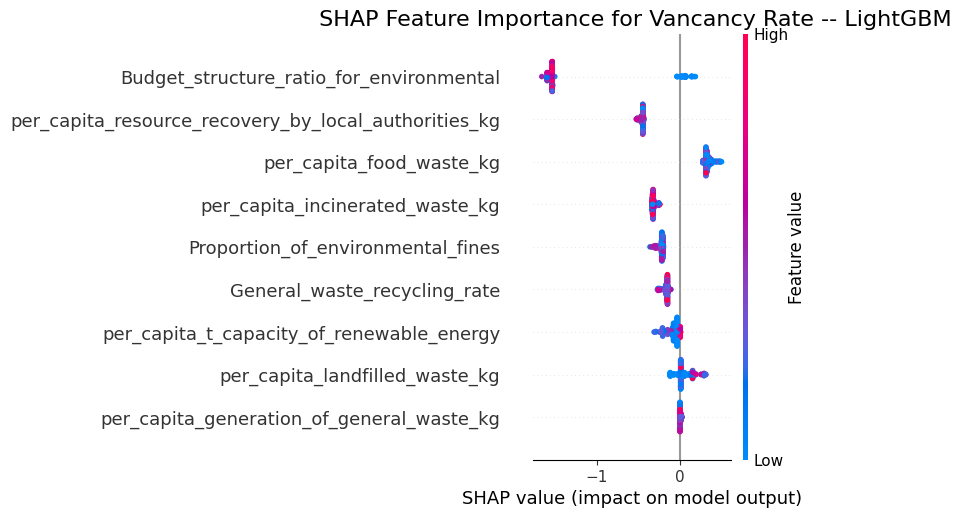

In [28]:
### shap value test--- Vancancy_rate

import shap

xgb_model = pipeline_xg.named_steps['xgb']
rf_model = pipeline_rf.named_steps['rf']
lgbm_model = pipeline_lgbm.named_steps['lgbm']
cat_model = pipeline_cat.named_steps['cat']


explainer2 = shap.Explainer(rf_model, X)  # rf_model 是你訓練過的 Random Forest
shap_values2 = explainer2(X)

# 1. 準備 SHAP explainer
explainer1 = shap.TreeExplainer(xgb_model)  # 這裡用 XGBoost 訓練好的模型
explainer3 = shap.TreeExplainer(cat_model)
explainer4 = shap.TreeExplainer(lgbm_model)
# 2. 計算 shap value
shap_values1 = explainer1.shap_values(X)
shap_values3 = explainer3.shap_values(X)
shap_values4 = explainer4.shap_values(X)

# plotting
shap.summary_plot(shap_values1, X, show =False)
plt.title(" SHAP Feature Importance for Vancancy Rate -- Xgboost", fontsize=16)
plt.show()

shap.plots.beeswarm(shap_values2, show= False)
plt.title(" SHAP Feature Importance for Vancancy Rate -- Random Forest", fontsize=16)
plt.show()

shap.summary_plot(shap_values3, X, show =False)
plt.title(" SHAP Feature Importance for Vancancy Rate -- Catboost", fontsize=16)
plt.show()

shap.summary_plot(shap_values4, X, show =False)
plt.title(" SHAP Feature Importance for Vancancy Rate -- LightGBM", fontsize=16)
plt.show()


#### Shap values do not consist with feature importance above is normal HAHHAHAH

In [29]:
# 2. 计算 SHAP 值并统一转换为 numpy 数组
def get_shap_values(explainer, X):
    shap_values = explainer.shap_values(X)
    # 处理不同返回类型
    if isinstance(shap_values, list):
        # 分类问题会返回列表，取第一个元素
        return np.array(shap_values[0]) if len(shap_values) == 2 else np.array(shap_values)
    elif hasattr(shap_values, 'values'):
        return shap_values.values
    else:
        return np.array(shap_values)

shap_values1 = get_shap_values(explainer1, X)
shap_values2 = get_shap_values(explainer2, X)
shap_values3 = get_shap_values(explainer3, X)
shap_values4 = get_shap_values(explainer4, X)

# 3. 提取SHAP值到DataFrame
shap_df = pd.DataFrame({
    "feature": X.columns,
    "shap_avg_xgb": shap_values1.mean(axis=0),
    "shap_std_xgb": shap_values1.std(axis=0),
    "shap_avg_rf": shap_values2.mean(axis=0),
    "shap_std_rf": shap_values2.std(axis=0),
    "shap_avg_cat": shap_values3.mean(axis=0),
    "shap_std_cat": shap_values3.std(axis=0),
    "shap_avg_lgbm": shap_values4.mean(axis=0),
    "shap_std_lgbm": shap_values4.std(axis=0),
}).sort_values("shap_avg_xgb", ascending=False)

print("SHAP值摘要：\n", shap_df)

SHAP值摘要：
                                              feature  shap_avg_xgb  \
7                           per_capita_food_waste_kg      1.146452   
2                  Proportion_of_environmental_fines      0.273169   
3                    per_capita_incinerated_waste_kg      0.092692   
6          per_capita_t_capacity_of_renewable_energy      0.009277   
4                     per_capita_landfilled_waste_kg     -0.031962   
8  per_capita_resource_recovery_by_local_authorit...     -0.112751   
5          per_capita_generation_of_general_waste_kg     -0.126979   
0                       General_waste_recycling_rate     -0.225604   
1           Budget_structure_ratio_for_environmental     -1.418449   

   shap_std_xgb  shap_avg_rf  shap_std_rf  shap_avg_cat  shap_std_cat  \
7      0.156499     0.000000     0.000000      0.786283      0.032185   
2      0.083767     0.000072     0.001415     -0.201036      0.060316   
3      0.104532     0.000000     0.000000      0.268441      0.041265 

# Fine turning, Hyperparametisation 